In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/celeba-dataset/list_landmarks_align_celeba.csv
/kaggle/input/celeba-dataset/list_eval_partition.csv
/kaggle/input/celeba-dataset/list_attr_celeba.csv
/kaggle/input/celeba-dataset/list_bbox_celeba.csv


KeyboardInterrupt: 

In [123]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celeba-dataset


In [124]:
import pandas as pd

df = pd.read_csv("/kaggle/input/celeba-dataset/list_attr_celeba.csv", delimiter=",")

In [125]:
df.Smiling.value_counts()

Smiling
-1    104930
 1     97669
Name: count, dtype: int64

In [126]:
df2=df[['image_id','Smiling']]
df2=df2.replace({-1:0})

In [127]:
from torch.utils.data import Dataset, DataLoader

In [147]:
import os 
from PIL import Image
target_folder = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"
file = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
class FaceImage(Dataset):
    def __init__(self, label_file, img_dir, transform=None):
        df = pd.read_csv(label_file, delimiter=",")
        df2=df[['image_id','Smiling']]
        df2=df2.replace({-1:0})
        self.labels  = df2[['image_id', 'Smiling']].copy()
        self.img_dir = img_dir
        self.transform = transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels.iloc[idx,0] ) 
        img = Image.open(img_path).convert("RGB")
        label = self.labels.iloc[idx,1]

        if self.transform:
            img = self.transform(img)
            
        return img, label 

    def __len__(self):
        return self.labels.shape[0]


In [148]:
trans = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.ToTensor()
    ]
)

data = FaceImage(file,target_folder, trans )
tmp_img, tmp_label = data[4596]

In [149]:
type(tmp_img)

torch.Tensor

In [150]:
tmp_img

tensor([[[0.5412, 0.5412, 0.5412,  ..., 0.5490, 0.5490, 0.5529],
         [0.5412, 0.5412, 0.5412,  ..., 0.5490, 0.5490, 0.5529],
         [0.5412, 0.5412, 0.5412,  ..., 0.5490, 0.5529, 0.5569],
         ...,
         [0.8510, 0.8510, 0.8118,  ..., 0.6235, 0.5255, 0.4314],
         [0.8196, 0.8275, 0.8353,  ..., 0.6706, 0.5294, 0.4471],
         [0.7098, 0.7059, 0.6941,  ..., 0.5765, 0.6235, 0.3961]],

        [[0.7255, 0.7255, 0.7255,  ..., 0.7333, 0.7333, 0.7373],
         [0.7255, 0.7255, 0.7255,  ..., 0.7333, 0.7333, 0.7373],
         [0.7255, 0.7255, 0.7255,  ..., 0.7333, 0.7373, 0.7412],
         ...,
         [0.7843, 0.7922, 0.7647,  ..., 0.5020, 0.4196, 0.3176],
         [0.7647, 0.7765, 0.7922,  ..., 0.5490, 0.4157, 0.3294],
         [0.6706, 0.6706, 0.6588,  ..., 0.4549, 0.4941, 0.2745]],

        [[0.9373, 0.9373, 0.9373,  ..., 0.9451, 0.9451, 0.9490],
         [0.9373, 0.9373, 0.9373,  ..., 0.9451, 0.9451, 0.9490],
         [0.9373, 0.9373, 0.9373,  ..., 0.9451, 0.9490, 0.

In [153]:
from torch.utils.data import random_split


In [154]:
len(data) *0.7

141819.3

In [155]:
sum([141819, 20261,40519])

202599

In [181]:
from torch.utils.data import random_split
import torch
gen = torch.Generator().manual_seed(42) # 
train_datase, val_dataset, test_dataset = random_split(data,[141819, 20261,40519],generator=gen)

In [182]:
from torch.utils.data import DataLoader
from torchvision import transforms

In [183]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, 
                         num_workers=2)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=True,num_workers=2  # 테스트 시에도 shuffle=True 권장 (평가 편향 방지)
)

In [159]:
a=iter(train_loader)

In [160]:
tmp = next(a)

In [161]:
tmp[0].shape

torch.Size([32, 3, 64, 64])

In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # 신경망 함수(활성화 함수 등)


In [163]:
# 2. 장치(GPU/CPU) 자동 선택
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')  # GPU 사용 가능하면 GPU로
else:
    DEVICE = torch.device('cpu')   # 아니면 CPU로
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.6.0+cu124  Device: cuda


In [164]:
DEVICE

device(type='cuda')

In [165]:
# 3. 하이퍼파라미터(학습 설정값) 지정
BATCH_SIZE = 32  # 한 번에 읽어올 데이터 개수(메모리 상황에 따라 조정)
EPOCHS = 5      # 전체 데이터셋을 몇 번 반복 학습할지(에포크 수)

In [166]:
# 6. 데이터 구조(Shape) 확인
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())  # 이미지 텐서 크기/타입
    print('y_train:', y_train.size(), 'type:', y_train.type())  # 라벨 크기/타입
    break  # 첫 배치만 확인

X_train: torch.Size([32, 3, 64, 64]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


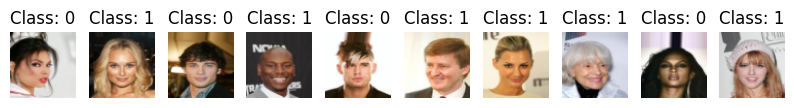

In [167]:
# 7. 샘플 이미지 10개 시각화
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)  # 1행 10열 중 i+1번째
    plt.axis('off')  # 축 숨기기
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))  # [채널, 높이, 너비] → [높이, 너비, 채널] 변환
    plt.title('Class: ' + str(y_train[i].item()))
# 초보자 팁: 데이터가 잘 불러와졌는지, 이미지와 라벨이 맞는지 꼭 시각화로 확인!

In [170]:
# 8. CNN 모델 정의
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # 첫 번째 합성곱: 3채널 입력 → 16채널 출력, 3x3 커널, 패딩 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64 → 32x32

        # 두 번째 합성곱: 16채널 입력 → 32채널 출력
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32 → 16x16

        # 세 번째 합성곱: 32채널 입력 → 64채널 출력
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # 16x16 → 8x8

        # 완전연결층: 8x8x64 → 128 → num_classes
        self.fc1 = nn.Linear(8*8*64, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [174]:
# 9. 모델, 옵티마이저, 손실 함수 설정
model = CNN().to(DEVICE)  # 모델을 GPU/CPU로 이동
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류용 손실 함수

# 초보자 팁: optimizer와 criterion은 학습의 핵심 도구!

In [172]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [173]:
from torchinfo import summary

In [175]:
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            448
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            4,640
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            18,496
├─ReLU: 1-8                              --
├─MaxPool2d: 1-9                         --
├─Linear: 1-10                           524,416
├─ReLU: 1-11                             --
├─Linear: 1-12                           1,290
Total params: 549,290
Trainable params: 549,290
Non-trainable params: 0

In [178]:
# 13. 평가(테스트) 함수 정의
def evaluate(model, test_loader):
    model.eval()  # 평가 모드
    test_loss = 0
    correct = 0

    with torch.no_grad():  # 평가 시에는 그래디언트 계산 안함
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]  # 예측 클래스
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)  # 평균 손실
    test_accuracy = 100. * correct / len(test_loader.dataset)  # 정확도(%)
    return test_loss, test_accuracy

# 초보자 팁: 평가 함수는 학습 도중/후에 모델의 실제 성능을 확인하는 데 사용!

In [184]:
# 14. 학습 및 평가 반복
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200)  # 한 번 학습
    test_loss, test_accuracy = evaluate(model, test_loader)  # 테스트
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

# 초보자 팁:
# - epoch: 전체 데이터셋을 한 번 학습하는 단위
# - test_accuracy: 모델의 분류 정확도(%)를 의미

Train Epoch: 1 [0/40519 (0%)]	Train Loss: 0.233299
Train Epoch: 1 [6400/40519 (16%)]	Train Loss: 0.274066
Train Epoch: 1 [12800/40519 (32%)]	Train Loss: 0.157970
Train Epoch: 1 [19200/40519 (47%)]	Train Loss: 0.202754
Train Epoch: 1 [25600/40519 (63%)]	Train Loss: 0.149209
Train Epoch: 1 [32000/40519 (79%)]	Train Loss: 0.085816
Train Epoch: 1 [38400/40519 (95%)]	Train Loss: 0.130861

[EPOCH: 1], 	Test Loss: 0.2078, 	Test Accuracy: 91.31 % 

Train Epoch: 2 [0/40519 (0%)]	Train Loss: 0.182753
Train Epoch: 2 [6400/40519 (16%)]	Train Loss: 0.337237
Train Epoch: 2 [12800/40519 (32%)]	Train Loss: 0.109912
Train Epoch: 2 [19200/40519 (47%)]	Train Loss: 0.129976
Train Epoch: 2 [25600/40519 (63%)]	Train Loss: 0.315142
Train Epoch: 2 [32000/40519 (79%)]	Train Loss: 0.392219
Train Epoch: 2 [38400/40519 (95%)]	Train Loss: 0.276037

[EPOCH: 2], 	Test Loss: 0.2008, 	Test Accuracy: 91.68 % 

Train Epoch: 3 [0/40519 (0%)]	Train Loss: 0.085188
Train Epoch: 3 [6400/40519 (16%)]	Train Loss: 0.187216
Trai